# Directions:

This code fuses LRHSI and HRMSI of "WashingtonDC" dataset. (scale factor = 8)

- Run the following codes in sequence.

- To change the scale factor simply change the command (scale = 8) to (scale = 16) in the "Data Preparation for Fusion" section.

- The files needed (2 files) to run the code should be copied to a folder called "SSSR" in the root. ('/content/drive/MyDrive/SSSR/washDC280x280.mat') and
('/content/drive/MyDrive/SSSR/ikonos_SRF.mat')

# Setup, Initializations, Functions, and data loading


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ************************* Setup *****************************
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import sys
import time
from scipy.io import savemat
from os.path import dirname, join as pjoin
from matplotlib import pyplot
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Layer



In [3]:
# Assessment function
# ***********************************************************************
def assess(hsi_true, hsi_predicted, scale):
  x = hsi_true
  y = hsi_predicted
  hd=x.shape
  n = hd[0]*hd[1]
  L = hd[2]
  metric = np.zeros((7)) # metrics are: RMSE, PSNR, SAM, ERGAS, UIQI, MSSIM, CC
  # **************** RMSE ****************
  temp = np.sum(np.sum((x-y)*(x-y),axis=0),axis=0)/n
  rmse_per_band = np.sqrt(temp)
  metric[0] = np.sqrt(np.sum(temp)/L)
  metric[1]=10*np.log10(1/metric[0]**2)
  # **************** SAM ****************
  num = np.sum( x*y,axis=2 )
  den = np.sqrt( np.sum(x*x,axis=2)*np.sum(y*y,axis=2) )
  tt = num/den
  sam = np.mean( np.arccos( num/den ) )
  metric[2]=sam*180/3.14159
  # **************** ERGAS ****************
  mean_y = np.sum(np.sum(y,axis=0),axis=0)/n
  metric[3] = 100/scale*np.sqrt(np.sum((rmse_per_band / mean_y)**2)/L)
  # **************** UIQI ****************
  wind_size=32
  z0=hd[0]-np.remainder(hd[0],wind_size)
  z1=hd[1]-np.remainder(hd[1],wind_size)
  z2=hd[2]
  ii=np.arange(0,z0,wind_size)
  jj=np.arange(0,z1,wind_size)
  n_wind=np.size(ii) * np.size(jj)
  count=0
  t1=np.zeros((wind_size,wind_size,z2,n_wind))
  t2=np.zeros((wind_size,wind_size,z2,n_wind))
  for i in ii:
    for j in jj:
      t1[:,:,:,count]=x[i:i+wind_size,j:j+wind_size,:]
      t2[:,:,:,count]=y[i:i+wind_size,j:j+wind_size,:]
      count=count+1
  mu_x=np.mean(np.mean(t1,axis=0),axis=0)
  mu_y=np.mean(np.mean(t2,axis=0),axis=0)
  sig2_x=np.mean(np.mean(t1**2,axis=0),axis=0) - mu_x**2
  sig2_y=np.mean(np.mean(t2**2,axis=0),axis=0) - mu_y**2
  cov_xy=np.mean(np.mean(t1*t2,axis=0),axis=0)-mu_x*mu_y
  t3 = ( 4 * cov_xy * mu_x * mu_y ) / ( (sig2_x + sig2_y)*(mu_x**2 + mu_y**2) )
  metric[4] = np.mean(t3)
  # **************** MSSIM ****************
  c1=.0001
  c2=.0001
  ssim = np.zeros((hd[2]))
  sigma2_x = np.zeros((hd[2]))
  sigma2_y = np.zeros((hd[2]))
  sigma_xy = np.zeros((hd[2]))
  mean_x = np.sum(np.sum(x,axis=0),axis=0)/n
  mean_y = np.sum(np.sum(y,axis=0),axis=0)/n
  for i in range(hd[2]):
    sigma2_x[i]=np.mean(x[:,:,i]**2)-mean_x[i]**2
    sigma2_y[i]=np.mean(y[:,:,i]**2)-mean_y[i]**2
    sigma_xy[i]=np.mean(x[:,:,i]*y[:,:,i])-mean_x[i]*mean_y[i]
    ssim[i] = ((2*mean_x[i]*mean_y[i]+c1)*(2*sigma_xy[i]+c2))/((mean_x[i]**2+mean_y[i]**2+c1)*(sigma2_x[i]+sigma2_y[i]+c2))
  metric[5]=np.mean(ssim)
  # ****************  CC  ****************
  cc = np.zeros((hd[2]))
  for i in range(hd[2]):
    cc[i]= np.sum((x[:,:,i]-mean_x[i])*(y[:,:,i]-mean_y[i])) / np.sqrt(np.sum((x[:,:,i]-mean_x[i])**2)*np.sum((y[:,:,i]-mean_y[i])**2))
  metric[6]=np.mean(cc)
  # print( metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6] )
  return metric



# Data Preparation for Fusion

Gaussian spatial degradation, (Scale factor = 8x)




In [14]:
# ************************ washDC 8x gaussian  ***************************

scale = 4
sig = scale/2.35482                                                   # sigma of gaussian blurring
var=0

# ******************************** HRHSI *********************************
temp = sio.loadmat('/content/drive/MyDrive/SSSR/washDC280x280.mat')
hrhsi=np.float64(temp['WDC280'])                                      # it is 280x280 pixel
hrhsi=hrhsi[24:,24:,:]                                                # a 256x256 cut of washDC
hrhsi=(hrhsi-np.min(hrhsi))/(np.max(hrhsi)-np.min(hrhsi))             # normalize in [0,1] interval
hd=hrhsi.shape
print('hrhsi shape = ', hd)

# ******************************* HRMSI Image **********************************
temp = sio.loadmat('/content/drive/MyDrive/SSSR/ikonos_SRF.mat')      # Ikonos Like SRF
temp = np.float64(temp['R'])                                          # original no. of channels = 103
# ******************************************************************************
R = np.zeros((temp.shape[0],hd[2]))                                   # stretch to 191 channels to adapt with washDC
R[:,0]=temp[:,0]
R[:,-1]=temp[:,-1]
for i in range(hd[2]-1):
  t=i*temp.shape[1]/hd[2]
  j=int(t)
  R[:,i]=(1+j-t)*temp[:,j] + (t-j)*temp[:,j+1]
for i in range(R.shape[0]):                                           # Normalizing SRF (R)
  R[i, :]=R[i, :] / np.sum(R,1)[i]

temp=np.zeros((hd[2], hd[0], hd[1]))                                  # HRMSI simulation
for i in range(hd[2]):
  temp[i, :, :]=hrhsi[:, :, i]
temp=temp.reshape(hd[2], hd[0]*hd[1])
temp = R @ temp
temp = temp.reshape(R.shape[0], hd[0], hd[1])
hrmsi=np.zeros((hd[0],hd[1],R.shape[0]))
for i in range(R.shape[0]):
  hrmsi[:,:,i]=temp[i,:,:]
md =  hrmsi.shape
print('hrmsi shape = ', md)

# ******************************** LRHSI *********************************
# ******* gaussian spatial degradation *******
lrhsi=cv.GaussianBlur(hrhsi,(scale+1,scale+1),sig) # sig=2
lrhsi=lrhsi[np.int16(np.arange(np.ceil(scale/2),hd[0],scale)), :, :]
lrhsi=lrhsi[:, np.int16(np.arange(np.ceil(scale/2),hd[1],scale)), :]

# ***************** Synthetic  Training Data Generation ******************
# ******* gaussian spatial degradation *******
ld = lrhsi.shape #(int(hd[0]/scale), int(hd[1]/scale),hd[2])
print('lrhsi shape = ', ld)

lrdata=np.zeros((ld[0]*ld[1],ld[2]))
mrdata=np.zeros((ld[0]*ld[1],md[2]))

temp=cv.GaussianBlur(hrmsi,(scale+1,scale+1),sig) # sig=2
temp=temp[np.int16(np.arange(np.ceil(scale/2),hd[0],scale)), :, :]
temp=temp[:, np.int16(np.arange(np.ceil(scale/2),hd[1],scale)), :]
count=0
for i in range(ld[0]):
  for j in range(ld[1]):
    lrdata[count,:]=lrhsi[i,j,:]
    mrdata[count,:]=temp[i,j,:]
    count=count+1

# np.save('/content/drive/MyDrive/SSSR/hrmsi.npy',hrmsi)
# np.save('/content/drive/MyDrive/SSSR/hrhsi.npy',hrhsi)
# np.save('/content/drive/MyDrive/SSSR/lrhsi.npy',lrhsi)
# np.save('/content/drive/MyDrive/SSSR/lrdata.npy',lrdata)
# np.save('/content/drive/MyDrive/SSSR/mrdata.npy',mrdata)

print('scale = ', scale)
print('number of data = ', lrdata.shape[0])
print('mrdata.shape = ', mrdata.shape)
print('lrdata.shape = ', lrdata.shape)



hrhsi shape =  (256, 256, 191)
hrmsi shape =  (256, 256, 4)
lrhsi shape =  (64, 64, 191)
scale =  4
number of data =  4096
mrdata.shape =  (4096, 4)
lrdata.shape =  (4096, 191)


# Model

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 msi_input (InputLayer)      [(None, 4)]               0         
                                                                 
 dense_6 (Dense)             (None, 63)                378       
                                                                 
 dense_7 (Dense)             (None, 127)               8255      
                                                                 
 hsi_output (Dense)          (None, 191)               24639     
                                                                 
Total params: 33272 (129.97 KB)
Trainable params: 33272 (129.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


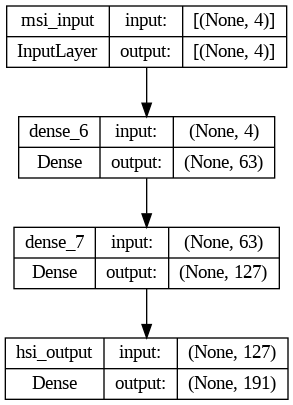

In [15]:
hsi_bands=hd[2]
msi_bands=md[2]

from tensorflow.keras.layers import Layer
class PReLU(Layer):
    def __init__(self, alpha_initializer=tf.constant_initializer(0.25), **kwargs):
        super(PReLU, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)
    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(input_shape[-1],),
                                     initializer=self.alpha_initializer,
                                     name='alpha',
                                     dtype=tf.float32)
        super(PReLU, self).build(input_shape)
    def call(self, inputs):
        return tf.maximum(0.0, inputs) + self.alpha * tf.minimum(0.0, inputs)

# ****************************** MSI Encoder ******************************
msi_input = keras.Input(shape=(msi_bands), name="msi_input")
x = layers.Dense(units=int(hsi_bands/3), activation=PReLU())(msi_input)
x = layers.Dense(units=int(2*hsi_bands/3), activation=PReLU())(x)
hsi_output = layers.Dense(units=hsi_bands, activation=PReLU(), name="hsi_output")(x)


model = keras.Model(inputs=[msi_input], outputs=[hsi_output],)

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss={"hsi_output": keras.losses.MeanSquaredError(),},)

model.summary()

keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)


# Training

In [16]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss={"hsi_output": keras.losses.MeanSquaredError(),},
)

nepoch = 500

model.fit(
    {"msi_input" : mrdata},
    {"hsi_output": lrdata},
    epochs=nepoch,
    batch_size=32,
)

# model.save('/content/drive/MyDrive/SSSR/models_trained_models/washDC_8X')

Epoch 1/500
128/128 [==============================] - 1s 2ms/step - loss: 0.0133
Epoch 2/500
128/128 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 3/500
128/128 [==============================] - 0s 2ms/step - loss: 5.3302e-04
Epoch 4/500
128/128 [==============================] - 0s 2ms/step - loss: 4.7221e-04
Epoch 5/500
128/128 [==============================] - 0s 2ms/step - loss: 4.2225e-04
Epoch 6/500
128/128 [==============================] - 0s 2ms/step - loss: 3.2868e-04
Epoch 7/500
128/128 [==============================] - 0s 2ms/step - loss: 2.8725e-04
Epoch 8/500
128/128 [==============================] - 0s 2ms/step - loss: 2.5335e-04
Epoch 9/500
128/128 [==============================] - 0s 2ms/step - loss: 2.3238e-04
Epoch 10/500
128/128 [==============================] - 0s 2ms/step - loss: 2.1501e-04
Epoch 11/500
128/128 [==============================] - 0s 2ms/step - loss: 2.0500e-04
Epoch 12/500
128/128 [==============================] - 0s 2

# Reconstruction and Assessment

In [17]:
start_time = time.time()

# md=hrmsi.shape
mrdatainput=np.zeros((md[0]*md[1], md[2]))
count=0
for i in range(md[0]):
  for j in range(md[1]):
    mrdatainput[count,:]=hrmsi[i,j,:]
    count=count+1
# **************************      Prediction      ****************************
impred = model.predict(mrdatainput, verbose=0)
# ************************      reconstruction      **************************
count=0
hd=hrhsi.shape
reconstoutput=np.zeros(hd)
count=0
for i in range(hd[0]):
  for j in range(hd[1]):
    reconstoutput[i,j,:]=impred[count,:]
    count=count+1

end_time = time.time()
execution_time = end_time - start_time
print("Reconstruction Time :", "{:.1f}".format(execution_time), "s\n")


# ***************** Assessment of washDC 8x - gaussian  1000 epoch   **************************
print('RMSE     PSNR      SAM      ERGAS    UIQI     SSIM     CC')
temp = assess(hrhsi, reconstoutput, scale)
print("{:.4f}  ".format(temp[0]), "{:.2f}    ".format(temp[1]), "{:.2f}    ".format(temp[2]), "{:.3f}   ".format(temp[3]),\
      "{:.4f}  ".format(temp[4]), "{:.4f}  ".format(temp[5]), "{:.4f}  ".format(temp[6]))


Reconstruction Time : 5.4 s

RMSE     PSNR      SAM      ERGAS    UIQI     SSIM     CC
0.0100   40.04     1.46     1.814    0.9924   0.9968   0.9947  
